## Transfer Learning
- Wifi y LTE
- pytorch


In [10]:
#Listo las carpetas que contiene el dataset
!ls '/home/student1/notebook/dataset/teleco_signal/'

ls: no se puede acceder a '/home/student1/notebook/dataset/teleco_signal/': Permiso denegado


In [11]:
#Verifico la capacidad de GPU
!nvidia-smi

Mon Nov 18 03:17:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:41:00.0 Off |                  N/A |
| 59%   77C    P2            116W /  320W |    9969MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy

Carga de las imágenes para entrenamiento

La normalizacion de las imágenes utiliza datos de Imagenet [0.485, 0.456, 0.406],                       [0.229, 0.224, 0.225]

Para val se añadio data augmentation, al tener pocas imagenes.

In [13]:
# Cargar las imagenes - datset

train_dataset = torchvision.datasets.ImageFolder('../../dataset/ganado/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])  # De imagenet
                                                    
                                                ]))
val_dataset = torchvision.datasets.ImageFolder('../../dataset/ganado/validation',
                                                  transform=transforms.Compose([
                                                  transforms.RandomRotation(10), 
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Resize(256),  
                                                  transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

test_dataset = torchvision.datasets.ImageFolder('../../dataset/ganado/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../../dataset/ganado/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 300
    Root location: ../../dataset/ganado/validation
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 300
    Root location: ../../dat

Se prepara los "loader" para train, val y test. Se utilizara un batch_size = 32


In [14]:
# imprimo un resumen de los datos
print('Train:', len(train_dataset))

Train: 3000


In [15]:
import os
from torch.utils.data.sampler import SubsetRandomSampler # type: ignore

batch_size = 4
learning_rate = 0.001
num_epocas = 40
step_log = 100
num_workers = os.cpu_count()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size = batch_size, num_workers=num_workers,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size, num_workers=num_workers,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size, num_workers=num_workers,
                                         shuffle=True)

class_names = train_dataset.classes
print(f"Usando {num_workers} workers para cargar datos.")

Usando 64 workers para cargar datos.


Se visualiza 4 imágenes de un batch tomados de train_loader, se añade los datos de normalizacion para la correcta visualizacion de las imágenes

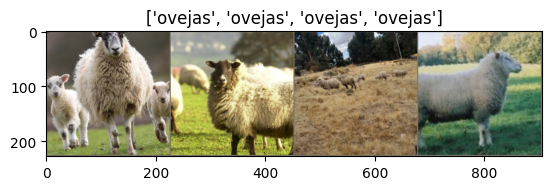

In [16]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

GPU para el enternamiento, verifico que se utilize CUDA
0-> para el primer gpu
1-> para seleccionar el segundo GPU en caso se tuviera

In [17]:
torch.cuda.set_device(1) 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


Arquitectura de la red

In [18]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 256, kernel_size=3)    
    self.bn1 = nn.BatchNorm2d(256)    
    self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
    #512 de la capa previa, 26 tamaño de la imagen
    self.fc1 = nn.Linear(512*26*26,50)  #Una capa full conected, 50 es el numero de neuronas q quiero 
    self.fc2 = nn.Linear(50,3) #son  clases
    
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)  #2 el tamaño de la ventana de pooling
    #x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    #x = F.relu(self.conv3(x)
    #x = x.view(-1,30*5*5) #al valor de x le hago un, -1 desdoblo las dimensiones a un size de 320
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x)
  
  def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

network = Network()

In [19]:
network = network.to(device)

Función de entrenamiento para train y val

Se añade comentarios tomados de la documentación y foros explicando el proceso y parámetros utilizados

In [20]:
#Modelo
def train_model(model, criterio, optimizer, scheduler, num_epochs):  
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)
    
        #Train model
        #During an epoch, we need to update the LR using the ‘.step()’ method of the scheduler object
        scheduler.step()
        #Tells your model that you are training the model
        model.train()
    
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            #In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
            #because PyTorch accumulates the gradients on subsequent backward passes.
            optimizer.zero_grad()
        
            outputs = model(inputs)
        
            #Si utilizo softmax, puedo usar exp
            #We are doing it here just to make our predictions look like probabilities 
            #which sometimes helps in debugging. You are free to remove torch.exp 
            #call in the code if you want. torch.max returns a tuple containing the maximum value 
            #and the index of the maximum value within the tensor. Since the index in our case 
            #represents the classified category itself, we will only take that ignoring 
            #the actual probability.
            #_, preds = torch.max(torch.exp(outputs), 1)
        
            #pytorch.max
            #Returns the maximum value of all elements in the input tensor.
            _, preds = torch.max(outputs, 1)
        
            #you should use labels, because u need to get loss by comparing ground truth 
            #and predicting label, the predict is outputs, and the ground truth is labels
            loss = criterion(outputs, labels)
        
            #loss.backward() computes dloss/dx for every parameter x which has 
            #requires_grad=True. These are accumulated into x.grad for every parameter x        
            loss.backward()
        
            #optimizer.step updates the value of x using the gradient x.grad
            optimizer.step()
        
            #the loss returned is an average over all examples in a batch, given this, 
            #you could simply divide the running loss by the number of batches, 
            #however since the final batch is often not the same size with others, 
            #your results would be inaccurate, hence, the solution is to reverse the average 
            #by multiplying the loss in a batch by the total number of images in the batch, 
            #this gives unaveraged sum of losses over all examples, when you divide the running loss 
            #by the total number of images ,you get accurate loss metrics.
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss_train = running_loss /len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)
    
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train
        
           
        #Validation 
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            #Context-manager that sets gradient calculation to on or off
            #Disabling gradient calculation is useful for inference, when you are sure that you will 
            #not call Tensor.backward(). It will reduce memory consumption for computations that would 
            #otherwise have requires_grad=True. 
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss_val = running_loss /len(val_dataset)
        epoch_acc_val = running_corrects.double() / len(val_dataset)
                   
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
                      
        if epoch_acc_val > best_acc:
              best_acc = epoch_acc_val
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'SP_cross.pth')
              
    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accucary: {:.4f}'.format(best_acc_train))
    print('Best val accucary: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

Funcion test

In [21]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
        
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return test_model

Visualizar el resultado, se utiliza imagenes en test

In [22]:
def visualize_model(model, num_images):
    was_training = model.training
    
    model.eval()
    images_so_far = 0
    
    #fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
                    
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images, 1, images_so_far)
                
                ax.axis('off')
                ax.set_title('Predicted: {} (Clase: {})'.format(class_names[preds[j]], class_names[labels[j]]))
                                
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return           
                
        model.train(mode = was_training)


torch.hub.list(github, force_reload=False, skip_validation=False)###Entrenamiento 1

Función de pérdida: CrossEntropyLoss

Optimizador: stochastic gradient descent SGD

In [23]:
import torchvision.models as models
model_ResNetXt = models.resnext50_32x4d()



In [24]:
# Arquitectura del modelo
model_ResNetXt

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [25]:
num_ft = model_ResNetXt.fc.in_features
model_ResNetXt.fc = nn.Linear(num_ft, 3)

In [26]:
# Modelo a GPU
model_ResNetXt = model_ResNetXt.to(device)

In [27]:
# FUncion de perdidad, optimizador, LR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ResNetXt.parameters(), lr = 0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Pruebo el entrenamiento con los datos de test

In [28]:
model_ResNetXt = train_model(model_ResNetXt, criterion, optimizer, scheduler, num_epochs=num_epocas)

Epoch 0/39
-------------------------


/home/student2/miniconda3/envs/upeu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 1.7534 Acc: 0.3627
Val Loss: 2.5275 Acc: 0.3333
Epoch 1/39
-------------------------
Train Loss: 1.3896 Acc: 0.3877
Val Loss: 1.9305 Acc: 0.3400
Epoch 2/39
-------------------------
Train Loss: 1.2097 Acc: 0.4220
Val Loss: 3.1135 Acc: 0.4400
Epoch 3/39
-------------------------
Train Loss: 1.1331 Acc: 0.4303
Val Loss: 1.2650 Acc: 0.4567
Epoch 4/39
-------------------------
Train Loss: 1.0970 Acc: 0.4573
Val Loss: 1.5402 Acc: 0.4567
Epoch 5/39
-------------------------
Train Loss: 1.0956 Acc: 0.4503
Val Loss: 2.0291 Acc: 0.4467
Epoch 6/39
-------------------------
Train Loss: 0.9947 Acc: 0.5130
Val Loss: 0.9809 Acc: 0.5433
Epoch 7/39
-------------------------
Train Loss: 0.9658 Acc: 0.5237
Val Loss: 1.2316 Acc: 0.5100
Epoch 8/39
-------------------------
Train Loss: 0.9662 Acc: 0.5283
Val Loss: 1.4474 Acc: 0.4967
Epoch 9/39
-------------------------
Train Loss: 0.9648 Acc: 0.5183
Val Loss: 1.0434 Acc: 0.5567
Epoch 10/39
-------------------------
Train Loss: 0.9668 Acc: 0.508

Visualización de resultados en test

In [29]:
model_ResNetXt_test = test_model(model_ResNetXt)

Test Loss: 1.0630 Acc: 0.5800


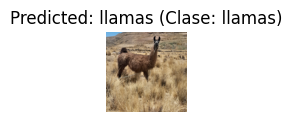

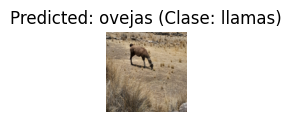

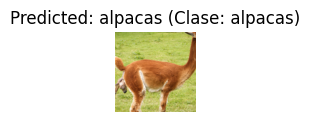

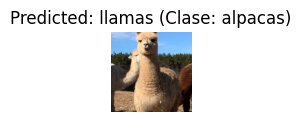

In [30]:
visualize_model(model=model_ResNetXt, num_images = 4)